In [1]:
from __future__ import print_function
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import itertools

import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import skimage.io as io
import pickle as pk
import copy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
class ArtistDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224), style = "Impressionism"):
        super(ArtistDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.style = style
        self.images_dir = os.path.join(root_dir, "%s/*.jpg" % style)
        if os.path.exists('%s.pkl' % style):
            with open('%s.pkl' % style, 'rb') as file:
                self.imgs = pk.load(file)
        else:
            self.imgs = io.ImageCollection(self.images_dir)
        if mode == 'train':
            self.imgs = self.imgs[:400]
        else:
            self.imgs = self.imgs[400:500]
    def __len__(self):
        return len(self.imgs)
    def __repr__(self):
        return "ArtistDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        #img = np.moveaxis(self.imgs[idx], [0,1,2], [1,2,0])
        img = Image.fromarray(self.imgs[idx])
        transform = tv.transforms.Compose([
        tv.transforms.Resize(self.image_size),
        #tv.transforms.RandomCrop(self.image_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])
        x = transform(img)
        return x, x

In [4]:
class LandDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224), style = "city"):
        super(LandDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.style = style
        self.images_dir = os.path.join(root_dir, "%s/*.jpg" % style)
        if os.path.exists('%s.pkl' % style):
            with open('%s.pkl' % style, 'rb') as file:
                self.imgs = pk.load(file)
        else:
            self.imgs = io.ImageCollection(self.images_dir)
        if mode == 'train':
            self.imgs = self.imgs[:400]
        else:
            self.imgs = self.imgs[400:500]
    def __len__(self):
        return len(self.imgs)
    def __repr__(self):
        return "LandDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        #img = np.moveaxis(self.imgs[idx], [0,1,2], [1,2,0])
        img = Image.fromarray(self.imgs[idx])
        transform = tv.transforms.Compose([
        tv.transforms.Resize(self.image_size),
        #tv.transforms.RandomCrop(self.image_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])
        x = transform(img)
        return x, x

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [6]:
artist_dataset_root_dir = '/datasets/ee285f-public/wikiart/wikiart/'
styles = ['Impressionism', 'Expressionism', 'Ukiyo_e', 'Baroque']
land_dataset_root_dir = '/datasets/ee285f-public/flickr_landscape/'
lands = ['city', 'mountain', 'forest', 'lake', 'ocean']

In [7]:
train_set_A = LandDataset(land_dataset_root_dir, style=lands[1])
train_set_B = ArtistDataset(artist_dataset_root_dir, style=styles[0])
val_set_A = LandDataset(land_dataset_root_dir, mode='val', style=lands[1])
val_set_B = LandDataset(artist_dataset_root_dir, mode='val', style=styles[0])

In [8]:
len(train_set_A)

400

In [9]:
len(train_set_B)

400

In [10]:
len(val_set_A)

100

In [11]:
len(val_set_B)

100

In [12]:
x, _ = val_set_A[40]

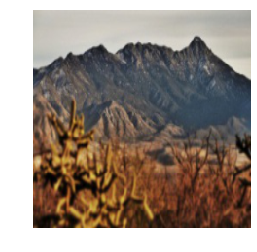

In [13]:
myimshow(x)

In [14]:
import nntools as nt
class Generator(nt.NeuralNetwork):
    def __init__(self, D, C=64):
        assert(D%2 == 0)
        assert(D>=4)
        super(Generator, self).__init__()
        import math
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        nn.init.kaiming_normal_(self.conv[0].weight.data)
        self.bn = nn.ModuleList()
        for k in range(D):
            if k < D/2:
                self.conv.append(nn.Conv2d(C, C, 3, dilation=int(math.pow(2,k)), padding=int(math.pow(2,k))))
            else:
                self.conv.append(nn.Conv2d(C, C, 3, dilation=int(math.pow(2,5-k)), padding=int(math.pow(2,5-k))))
            nn.init.kaiming_normal_(self.conv[k+1].weight.data)
            self.bn.append(nn.BatchNorm2d(C, C))
            nn.init.constant_(self.bn[k].weight.data, 1.25*np.sqrt(C))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        #nn.init.kaiming_normal_(self.conv[D+1].weight.data)
        
    def forward(self, x):
        import math
        features = []
        D = self.D
        torch.backends.cudnn.benchmark=True
        h = F.relu(self.conv[0](x))
        features.append(h)
        for k in range(D):
            if k < D//2-1:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
                features.append(h)
            elif k == D//2-1:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
            elif k == D/2:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
                h = (h + features[D-k-1])/math.sqrt(2)
            else:
                h = F.relu(self.bn[k](self.conv[k+1](h)))
                h = (h + features[D-k-1])/math.sqrt(2)
        h = (h + features[0])/math.sqrt(2)
        y = self.conv[D+1](h) + x
        torch.backends.cudnn.benchmark=False
        y = F.tanh(y)
        return y
    
    def criterion(self, y, d):
        pass

In [15]:
class Discriminator(nt.NeuralNetwork):
    # initializers
    def __init__(self, C=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, C, 4, 2, 1)
        self.conv2 = nn.Conv2d(C, C * 2, 4, 2, 1)
        self.conv2_norm = nn.InstanceNorm2d(C * 2)
        self.conv3 = nn.Conv2d(C * 2, C * 4, 4, 2, 1)
        self.conv3_norm = nn.InstanceNorm2d(C * 4)
        self.conv4 = nn.Conv2d(C * 4, C * 8, 4, 1, 1)
        self.conv4_norm = nn.InstanceNorm2d(C * 8)
        self.conv5 = nn.Conv2d(C * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_norm(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_norm(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_norm(self.conv4(x)), 0.2)
        x = self.conv5(x)
        return x
    
    def criterion(self, y, d):
        pass

In [16]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
class CycleGANStatsManager(nt.StatsManager):
    def __init__(self):
        super(CycleGANStatsManager, self).__init__()
    def init(self):
        super(CycleGANStatsManager, self).init()
        self.running_DA_loss = 0
        self.running_DB_loss = 0
        self.num = 0
    def accumulate(self, loss, DA, DB, x=None, y=None, d=None):
        super(CycleGANStatsManager, self).accumulate(loss, DA, DB, x, y, d)
        self.running_DA_loss += DA
        self.running_DB_loss += DB
        self.num += 1
    def summarize(self):
        loss = super(CycleGANStatsManager, self).summarize()
        DA_loss = self.running_DA_loss / self.num
        DB_loss = self.running_DB_loss / self.num
        return {'Gloss': loss, 'DALoss': DA_loss, 'DBLoss': DB_loss}

In [17]:
lrG = 0.0002
lrD = 0.0002
beta1 = 0.5
beta2 = 0.999
gnetA = Generator(D=6)
gnetB = Generator(D=6)
dnetA = Discriminator()
dnetB = Discriminator()
dnetA.weight_init(mean=0.0, std=0.02)
dnetB.weight_init(mean=0.0, std=0.02)
gnetA = gnetA.to(device)
gnetB = gnetB.to(device)
dnetA = dnetA.to(device)
dnetB = dnetB.to(device)
G_optimizer = optim.Adam(itertools.chain(gnetA.parameters(), gnetB.parameters()), lr=lrG, betas=(beta1, beta2))
D_A_optimizer = optim.Adam(dnetA.parameters(), lr=lrD, betas=(beta1, beta2))
D_B_optimizer = optim.Adam(dnetB.parameters(), lr=lrD, betas=(beta1, beta2))
stats_manager = CycleGANStatsManager()
exp1 = nt.Experiment(gnetA=gnetA, gnetB=gnetB, dnetA=dnetA, dnetB=dnetB, train_set_A=train_set_A, 
                     train_set_B=train_set_B, val_set_A=val_set_A, val_set_B=val_set_B, G_optimizer=G_optimizer, D_A_optimizer=D_A_optimizer, 
                     D_B_optimizer=D_B_optimizer, stats_manager=stats_manager, output_dir="cyclegan1", batch_size=4, 
                     perform_validation_during_training=True)

In [20]:
def plot(exp, fig, axes, realA, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        fakeB = exp.gnetA(realA[np.newaxis].to(exp.gnetA.device))[0]
        recA = exp.gnetB(fakeB[np.newaxis].to(exp.gnetB.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()
    myimshow(realA, ax=axes[0][0])
    myimshow(fakeB, ax=axes[0][1])
    myimshow(recA, ax=axes[0][2])
    axes[0][0].set_title('Real A image')
    axes[0][1].set_title('Generated B image')
    axes[0][2].set_title('Reconstructed A image')
    '''noisy_image = noisy.numpy()
    noisy_image = np.moveaxis(noisy_image, [0, 1, 2], [2, 0, 1])
    noisy_image[noisy_image < 0] = 0
    noisy_image[noisy_image > 1] = 1
    axes[0][0].imshow(noisy_image)'''
    axes[0][0].axis('off')
    '''denoised_image = denoised.cpu().numpy()
    denoised_image = np.moveaxis(denoised_image, [0, 1, 2], [2, 0, 1])
    denoised_image[denoised_image < 0] = 0
    denoised_image[denoised_image > 1] = 1
    axes[0][1].imshow(denoised_image)'''
    axes[0][1].axis('off')
    axes[0][2].axis('off')
    axes[1][0].plot([exp.history[k][0]['Gloss'] for k in range(exp.epoch)],label="training Gloss")
    axes[1][1].plot([exp.history[k][0]['DALoss'] for k in range(exp.epoch)],label="training DAloss")
    axes[1][2].plot([exp.history[k][0]['DBLoss'] for k in range(exp.epoch)],label="training DBloss")
    plt.tight_layout()
    fig.canvas.draw()

Start/Continue training from epoch 21


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 22 (Time: 125.47s)
Epoch 23 (Time: 127.19s)
Epoch 24 (Time: 119.00s)
Epoch 25 (Time: 121.30s)
Epoch 26 (Time: 131.41s)
Epoch 27 (Time: 116.27s)


KeyboardInterrupt: 

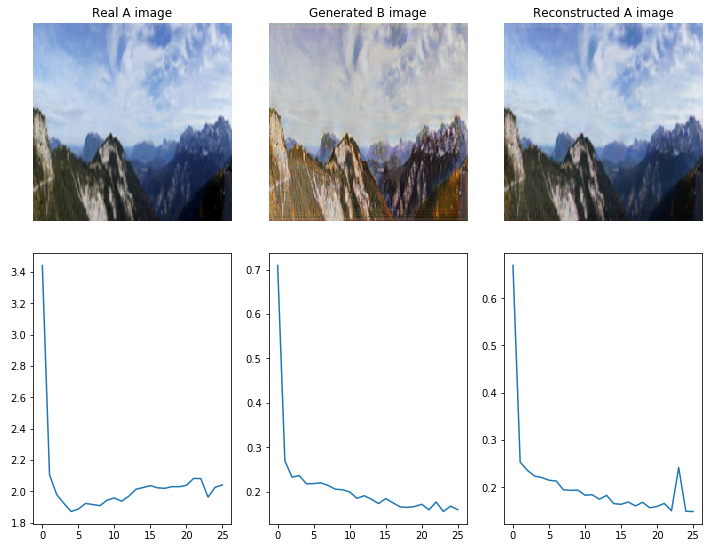

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,8))
exp1.run(num_epochs=200, decay_epoch=100, lrG=lrG, lrD=lrD, plot=lambda exp: plot(exp, fig=fig, axes=axes, realA=val_set_A[73][0]))

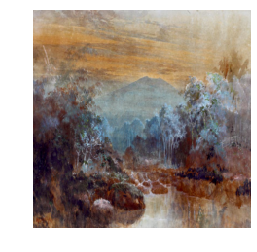

In [23]:
myimshow(train_set_B[10][0])